# Modeling Forecasting Tournament - OPTIONS

In [1]:
import itertools
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

## Goal

- with the model, I'd like to understand/quantify (at least a bit):
    - the **effect of randomness** on results
    - understanding how that depends on the **number of questions in a tournament**

### Conclusions:

- 25 questions is really quite a small number
- randomness plays a really big role
    - even if the effective number of questions (because of multiple-choice questions) would be e.g. 40 (realistic upper bound).

### Limitations:

- obviously, this depends on the model, which
    - models tournament as having only binary, yes/no questions
    - models forecasters maybe too simply?
    - might be buggy :-D
- multiple-choice questions with more options might behave differently
    - more possible answers mean lower probability that random overconfident guess gets it right
        - thus effectively increasing number of questions (/ bits of information learned from one question)
        - e.g. if all questions had 4 possible answers, that would be like effectively having 3x that many questions (3 = 4-1: the last answer is determined by the first 3)
    - on the other hand, ordered categorical scoring goes against this (by not penalizing enough)
     

In [2]:
def brier(outcome_yes, p_yes):
    return (outcome_yes - p_yes)**2 + ((1-outcome_yes) - (1-p_yes))**2
    # for yes/no: this is essentialy 
    #return 2 * (outcome_yes - p_yes)**2

In [13]:
# 3 examples
brier(np.array([1, 1, 1]), np.array([0, 0.05, 0.9]))

array([2.   , 1.805, 0.02 ])

## Model:

- tournament: each tournament is a set of questions
- question:
    - each question is modelled as a biased coin
    - it has true probability `q_p` (e.g. 60:40)
    - and one outcome `q_outcome` (head / tails, or 1 / 0) tossed according to `q_p`
    - probability `q_p` is sampled uniformly, from `[0.02, 0.98]`
        - (to exclude rare/super-likely events, tho this does not matter much)
- forecasters:
    - each forecaster is modelled as one parameter, **precision/true skill**, `f_std`
    - each of his predictions is sampled normally around true probability `q_p` with std = `f_std`
        - clipped to `[0, 1]` range
    - thus, `f_std == 0` corresponds to perfect forecaster (called **oracle**), who always predicts the true probability `q_p`

- DISCLAIMER: I don't know how good/reasonable this model is.

## Run the model:

In [5]:
%%time

# we will simulate tournaments of 2 - 300 questions
tournament_sizes = np.arange(2, 301)

# how many tournaments(/samples) for each set of questions
samples_per_tournament = 200

# how many forecasters in one tournament?
f_n = 350
# how many of the top forecasters are we trying to pick
f_top = 30

# store samples

# per question samples
# wisdom of crowd prediction, wisdom of crowd brier, median brier, true P, outcome_p
cw_perc, cw_p, cw_br, med_br, true_p, out_p = [],[],[],[],[],[]

# aggregations across different tournament sizes
per_size_aggs = []
for q_n in tournament_sizes:
    print('.', end='')
    # list of aggregations for one tournament round
    per_tournament_aggs = []
    for _ in range(samples_per_tournament):
        # questions, true P
        #q_p = np.random.uniform(0,1, size=q_n)
        q_p = np.random.uniform(0.02, 0.98, size=q_n)
        # questions, real outcome
        q_outcome = np.random.binomial(1, q_p, size=(1, q_n))[0]

        # forecasters: precision
        f_std = np.clip(np.random.normal(loc=0.2, scale=0.07, size=f_n), 0, 1)
        # oracle: at least one forecaster gets the true probs always exactly right (for the reference)
        f_std[0] = 0
        # so that top 30 forecasters are in first 30 indices
        f_std.sort()
        
        # predicion
        f_guess_p = np.clip(q_p[:, None] + np.random.normal(loc=0, scale=f_std, size=(q_n, f_n)), 0, 1)
        #f_guess_random = np.random.uniform(0,1,size=q_n)
        #f_guess_dunno = 0.5 * np.ones(q_n)
        
        # brier_scores for all questions & forecasters
        all_briers = brier(q_outcome[:, None], f_guess_p)
        # average brier score of forecaster in the tournament
        f_br = all_briers.mean(axis=0)
        # worst brier among the top-30
        f_br_top30_worst = f_br[:f_top].max()
        # index of forecaster with the lowest brier in this tournament
        best = np.argmin(f_br)
        # indices of 30 forecasters with lowest brier scores
        top_br_i = np.argsort(f_br)[:f_top]
        
        # wisdom of crowd
        crowd_p = f_guess_p.mean(axis=1)
        crowd_br = brier(q_outcome, crowd_p)
        # median brier score for each question
        q_median_br = np.median(all_briers, axis=1)
        
        # per question, no need to save a lot
        if len(true_p) < 10000:
            # what is percentile of the crowd for each question
            for q in range(q_n):
                cw_perc.append(stats.percentileofscore(all_briers[q], crowd_br[q]))
            cw_br.extend(crowd_br)
            cw_p.extend(crowd_p)
            true_p.extend(q_p)
            out_p.extend(q_outcome)
            med_br.extend(q_median_br)
        
        per_tournament_aggs.append((
            # what percentile of brier does the best forecaster (oracle) have?
            stats.percentileofscore(f_br, f_br[0]),
            
            # what percentile of skill does forecaster with lowest brier have?
            stats.percentileofscore(f_std, f_std[best]),
            
            # what is correlation between
            #  - forecasters' precision (the lower the better)
            #  - his brier (the lower the better)
            stats.pearsonr(f_std, f_br)[0],
            
            # what percentile of brier does the worst of top-30 forecasters have 
            stats.percentileofscore(f_br, f_br_top30_worst),
            
            # how many of forecasters with lowest brier are truly in the top 30?
            (top_br_i < f_top).sum()
        ))

    aggregates = map(np.array, zip(*per_tournament_aggs))
    per_size_aggs.append(list(itertools.chain.from_iterable(
        # from each of per_tournament_aggs statistics, aggregate accross all samples
        # by taking mean and std
        (stat.mean(), stat.std(ddof=1.5)) for stat in aggregates)))

cw_perc, cw_p, cw_br, med_br, true_p, out_p = map(np.array, (cw_perc, cw_p, cw_br, med_br, true_p, out_p))
print()

...........................................................................................................................................................................................................................................................................................................
CPU times: user 7min 13s, sys: 818 ms, total: 7min 14s
Wall time: 7min 14s


### Helper code

In [15]:
results = list(map(np.array, zip(*per_size_aggs)))

titles = [
    "What percentile in Brier does the best forecaster (oracle) ends up with?"
    + "\nOracle == always predicts the true probability."
    ,
    "How good (percentile of true skill) the forecaster with best brier is?"
    + "\nHow big a role does luck play? (lower value == less luck needed to win)",
    'How does true skill correlate with brier scores?',
    "What is the worst percentile in Brier of the top 30 forecasters?"
    + "\nIf we wanted to include true top-30 for sure,\nwhat brier percentile would the threshold be on average?",
    "Out of best 30 (by Brier), how many are on avg truly in top-30 (by skill)?"
         ]
ylabels = [
        "Percentile of Brier score",
        "Percentile of true skill\nforecaster with lowest brier",
        "Pearson's R",
        "Percentile of Brier score",
        "Count"
]
assert 2*len(titles) == len(results) and len(titles) == len(ylabels)

In [16]:
T_idx = 23
# our OPTIONS tournament has 25 questions, T_idx is the index
assert tournament_sizes[T_idx] == 25

### Analyze

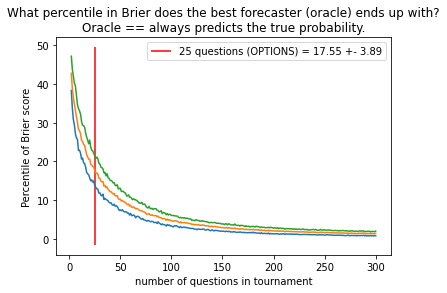

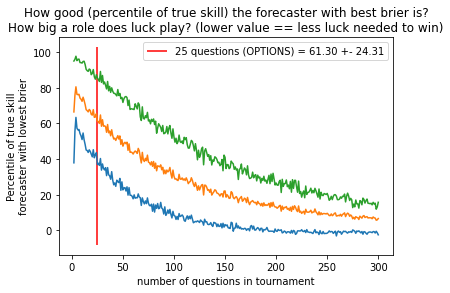

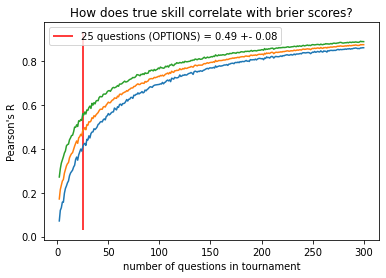

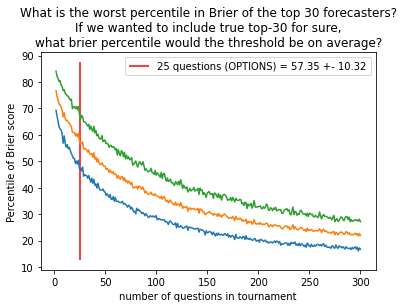

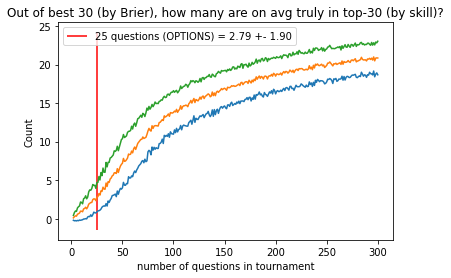

In [17]:
x = tournament_sizes

for i in range(len(titles)):
    plt.title(titles[i])
    plt.ylabel(ylabels[i])

    what, what_std = results[2*i], results[2*i+1]
    
    plt.plot(x, what - what_std)
    plt.plot(x, what)
    plt.plot(x, what + what_std)
    plt.xlabel("number of questions in tournament")
    
    # plot value for OPTIONS tournament (25 Q)
    if True:
        T_val, T_std = what[T_idx], what_std[T_idx]
        (xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()
        label = f"25 questions (OPTIONS) = {T_val:.2f} +- {T_std:.2f}"
        plt.vlines(25, ymin, ymax, color='red', label=label)
        plt.legend()
    plt.show()

## Analyze Wisdom of the Crowd behavior

**Conclusions**:
- no big difference between wisdom of crowd and median Brier score
- most of the time, wisdom of the crowd is better
- median is better in cases where event is not very probable, but happens anyway
- wisdom of crowds tends to systematically err on rare/almost-certain events
     - crowd is good when individual biases/errors even out
     - near edges (e.g. for rare event, say 1%),
       it is driven to center, because the forecasters that predict closer to 50:50 (e.g. 10% instead of true 1%)
       are not evened out (because even the most "pessimistic" forecasters can only predict 0%)
     - (this behavior really depends on the model; this is essentially caused by clipping predictions to [0,1])

mean difference -0.00171266 +- 0.0325866
mode in <-0.0192504, -0.0173399> ; P = 10.09%


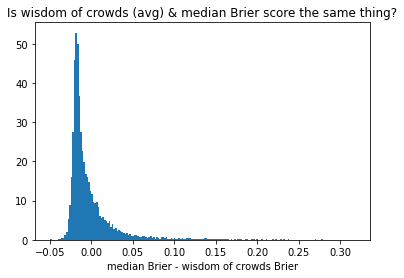

In [9]:
#cw_br, med_br, true_p
diff = med_br - cw_br
plt.title(f"Is wisdom of crowds (avg) & median Brier score the same thing?")
plt.xlabel(f"median Brier - wisdom of crowds Brier")

counts, bins, _ = plt.hist(diff, bins='auto', density=True)
mi = np.argmax(counts)
mu, std = diff.mean(), diff.std(ddof=1.5)
print(f"mean difference {mu:g} +- {std:g}")
print(f"mode in <{bins[mi]:g}, {bins[mi+1]:g}> ; P = {100*counts[mi]/counts.sum():.2f}%")

plt.show()

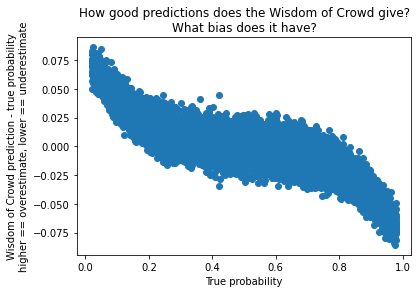

In [10]:
plt.title("How good predictions does the Wisdom of Crowd give?\nWhat bias does it have?")
plt.xlabel('True probability')
plt.ylabel('Wisdom of Crowd prediction - true probability\nhigher == overestimate, lower == underestimate')
_ = plt.scatter(true_p, cw_p - true_p)

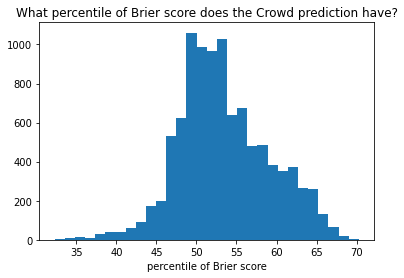

In [14]:
plt.title("What percentile of Brier score does the Crowd prediction have?")
plt.xlabel('percentile of Brier score')
_ = plt.hist(cw_perc, bins=30)

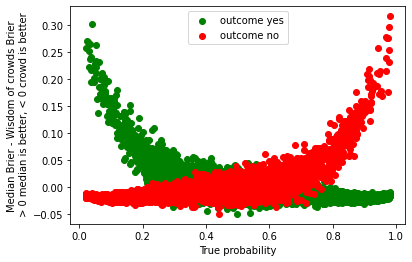

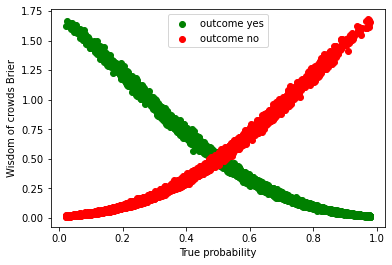

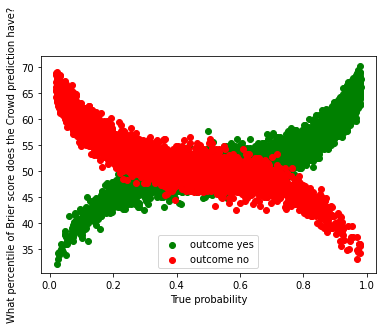

In [12]:
x,o = true_p, out_p

for ylabel, y in [
    ('Median Brier - Wisdom of crowds Brier\n > 0 median is better, < 0 crowd is better', med_br - cw_br),
    ('Wisdom of crowds Brier', cw_br),
    ("What percentile of Brier score does the Crowd prediction have?", cw_perc)
]:
    plt.ylabel(ylabel)
    plt.xlabel('True probability')
    plt.scatter(x[o==1],y[o==1],color='g', label='outcome yes')
    plt.scatter(x[o!=1],y[o!=1],color='r', label='outcome no')
    plt.legend()
    plt.show()